### Model Sentimen 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def map_sentiment(sentiment):
    if sentiment == 1:
        return 'positif'
    elif sentiment == 0:
        return 'netral'
    else:
        return 'negatif'

In [3]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y

In [4]:
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

### SGDClassifier

In [5]:
def plot_training_model_loss(clf, iterations, X, y):
    losses = []
    for i in range(iterations):
        clf.partial_fit(X, y, classes=np.unique(y))
        decision = clf.decision_function(X)
        hinge_loss = np.mean(np.maximum(0, 1 - decision[np.arange(len(y)), y]))
        losses.append(hinge_loss)
    plt.figure(figsize=(10, 6))
    plt.plot(range(iterations), losses, label='Training Loss')
    plt.title('Training Model')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
df = pd.read_csv('pre_title.csv')
df['sentimen'] = df['sentimen'].map(map_sentiment)
df.head(10)

,title,url_berita,sentimen
0,strategi sleman dorong ekonomi pakai batik int...,https://20.detik.com/blak-blakan/20231204-2312...,positif
1,greysia polii ajak anak muda terus melangkah r...,https://20.detik.com/demi-indonesia/20231027-2...,positif
2,pan x jakcloth pesta anak nongkrong sambangi b...,https://20.detik.com/advertorial/20231109-2311...,positif
3,arahan megawati rakernas iv pdip turun rakyatm...,https://20.detik.com/detikupdate/20231001-2310...,positif
4,erick thohir ajak muda tak mager indonesia leb...,https://20.detik.com/demi-indonesia/20231027-2...,positif
5,pdip sebut ganjar muliakan petani nelayan jadi...,https://20.detik.com/detikupdate/20231001-2310...,positif
6,bertemu habib rizieq cak imin bantah bahas duk...,https://20.detik.com/detikupdate/20231001-2310...,positif
7,kades bandung mundur dukung amin anies salut,https://20.detik.com/detikupdate/20231001-2310...,positif
8,gestur prabowo ditanya soal kans berduet ganjar,https://20.detik.com/detikupdate/20231001-2310...,positif
9,anies bertemu alumni itb bahas metode ilmiah m...,https://20.detik.com/detikupdate/20231001-2310...,positif


In [7]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['title'], df['sentimen'], test_data_proportion=0.3)

In [8]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]

In [9]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

In [10]:
print("Shape of tfidf_train_features:", tfidf_train_features.shape)
print("Length of y_train_encoded:", len(y_train_encoded))

Shape of tfidf_train_features: (10500, 70745)
Length of y_train_encoded: 10500


In [11]:
print("Shape of tfidf_test_features:", tfidf_test_features.shape)
print("Length of y_test_encoded:", len(y_test_encoded))

Shape of tfidf_test_features: (4500, 70745)
Length of y_test_encoded: 4500


In [12]:
# Model training with specified number of iterations
clf = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3)
clf.partial_fit(tfidf_train_features, y_train_encoded, classes=np.unique(y_train_encoded))

SGDClassifier()

In [13]:
# Predictions
clf_pred = clf.predict(tfidf_test_features)

# Accuracy
clf_accuracy = accuracy_score(y_test_encoded, clf_pred)
print("Accuracy:", clf_accuracy)

Accuracy: 0.7002222222222222


In [14]:
# Classification Report
report = classification_report(y_test_encoded, clf_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     negatif       0.69      0.70      0.69      1490
      netral       0.71      0.65      0.68      1484
     positif       0.70      0.75      0.72      1526

    accuracy                           0.70      4500
   macro avg       0.70      0.70      0.70      4500
weighted avg       0.70      0.70      0.70      4500



<Figure size 800x600 with 0 Axes>

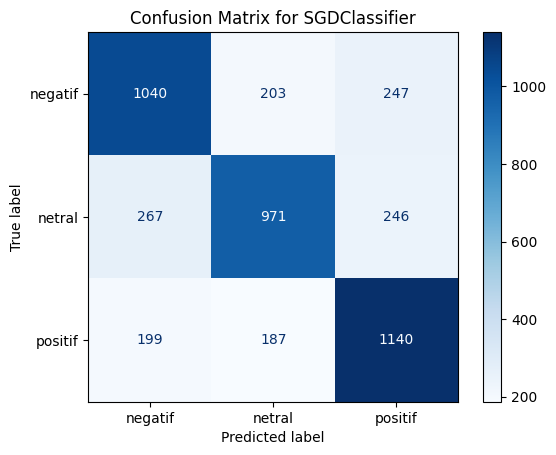

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, clf_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SGDClassifier')
plt.show()

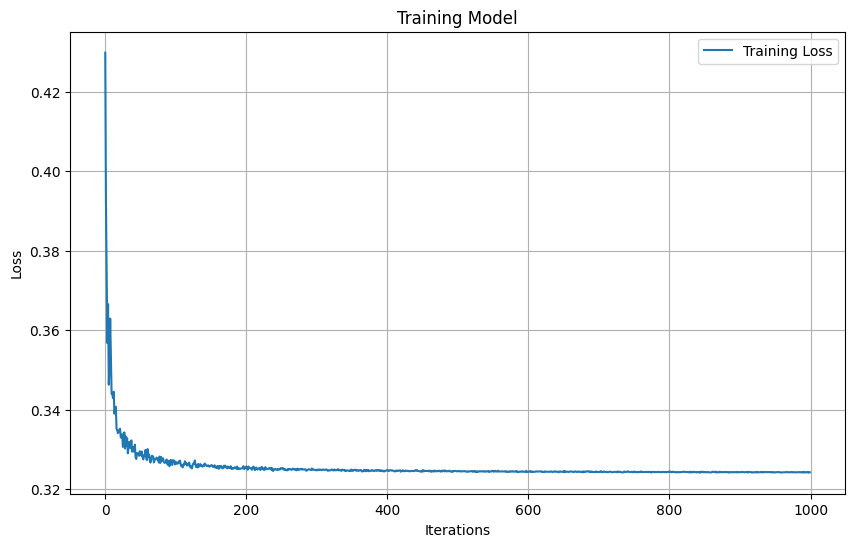

In [16]:
plot_training_model_loss(clf, 1000, tfidf_train_features, y_train_encoded)

### Naiye Bayes

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [18]:
# Train Naive Bayes model
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train_features, y_train_encoded)

MultinomialNB()

In [19]:
# Predictions
nb_pred = nb_classifier.predict(tfidf_test_features)

# Accuracy
nb_accuracy = accuracy_score(y_test_encoded, nb_pred)
print("Naive Bayes Accuracy:", nb_accuracy)

Naive Bayes Accuracy: 0.6682222222222223


In [20]:
# Classification Report
nb_report = classification_report(y_test_encoded, nb_pred, target_names=label_encoder.classes_)
print("Naive Bayes Classification Report:\n", nb_report)

Naive Bayes Classification Report:
               precision    recall  f1-score   support

     negatif       0.65      0.67      0.66      1490
      netral       0.69      0.60      0.64      1484
     positif       0.67      0.73      0.70      1526

    accuracy                           0.67      4500
   macro avg       0.67      0.67      0.67      4500
weighted avg       0.67      0.67      0.67      4500



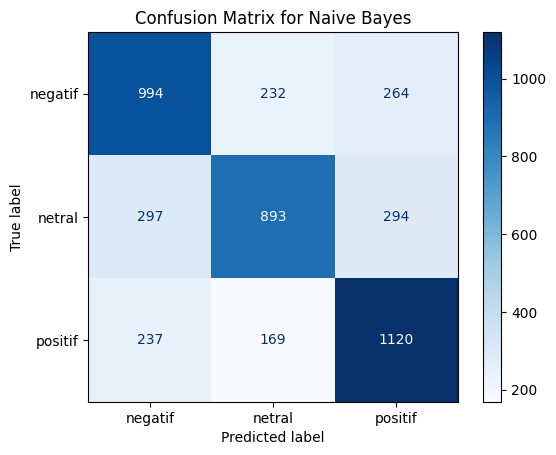

In [21]:
# Plot confusion matrix
nb_confusion_matrix = confusion_matrix(y_test_encoded, nb_pred)
nb_display = ConfusionMatrixDisplay(confusion_matrix=nb_confusion_matrix, display_labels=label_encoder.classes_)
nb_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

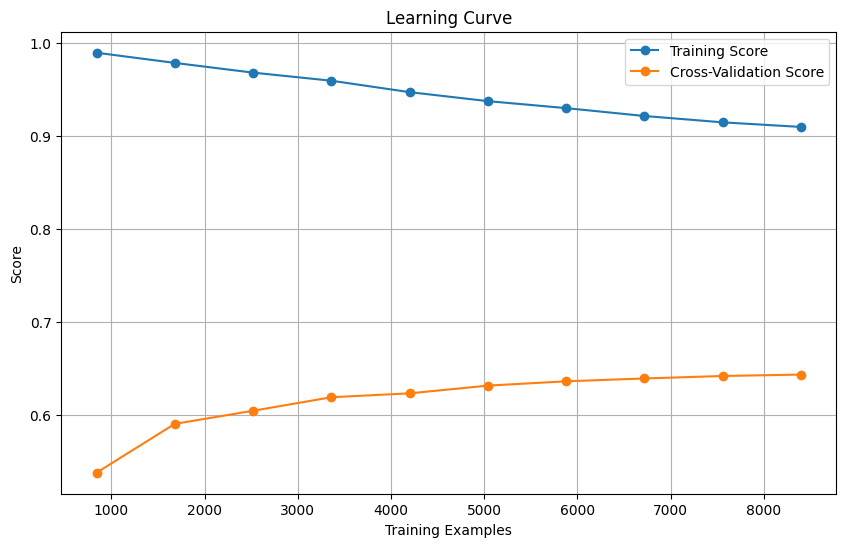

In [22]:
from sklearn.model_selection import learning_curve

# Define function to plot learning curve
def plot_learning_curve(estimator, X, y, train_sizes):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=train_sizes, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Score', marker='o')
    plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score', marker='o')
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot learning curve for Naive Bayes
plot_learning_curve(nb_classifier, tfidf_train_features, y_train_encoded, np.linspace(0.1, 1.0, 10))

### SVM Model

In [23]:
from sklearn.svm import SVC

In [24]:
# Train SVM model
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(tfidf_train_features, y_train_encoded)


SVC(kernel='linear')

In [25]:
# Predictions
svm_pred = svm_classifier.predict(tfidf_test_features)

# Accuracy
svm_accuracy = accuracy_score(y_test_encoded, svm_pred)
print("SVM Accuracy:", svm_accuracy)

SVM Accuracy: 0.7115555555555556


In [26]:
# Classification Report
svm_report = classification_report(y_test_encoded, svm_pred, target_names=label_encoder.classes_)
print("SVM Classification Report:\n", svm_report)

SVM Classification Report:
               precision    recall  f1-score   support

     negatif       0.71      0.72      0.71      1490
      netral       0.72      0.67      0.69      1484
     positif       0.71      0.75      0.73      1526

    accuracy                           0.71      4500
   macro avg       0.71      0.71      0.71      4500
weighted avg       0.71      0.71      0.71      4500



<Figure size 800x600 with 0 Axes>

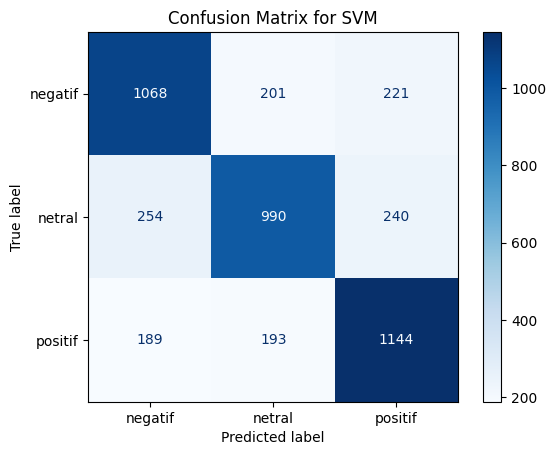

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

# Compute confusion matrix for SVM
svm_confusion_matrix = confusion_matrix(y_test_encoded, svm_pred)

# Plot confusion matrix for SVM
plt.figure(figsize=(8, 6))
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_confusion_matrix, display_labels=label_encoder.classes_)
svm_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SVM')
plt.show()

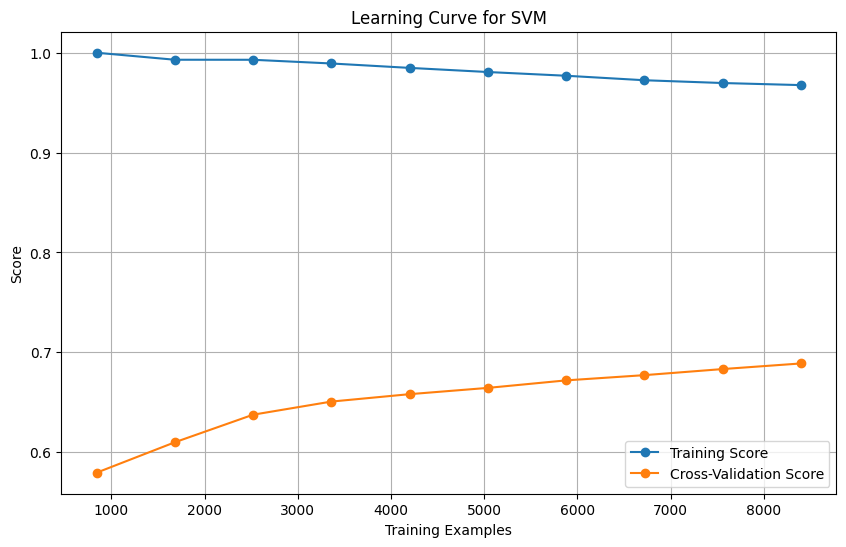

In [28]:
from sklearn.model_selection import learning_curve

# Define function to plot learning curve for SVM
def plot_learning_curve_svm(estimator, X, y, train_sizes):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=train_sizes, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Score', marker='o')
    plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score', marker='o')
    plt.title('Learning Curve for SVM')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot learning curve for SVM
plot_learning_curve_svm(svm_classifier, tfidf_train_features, y_train_encoded, np.linspace(0.1, 1.0, 10))

### Random Foresnt

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_classifier.fit(tfidf_train_features, y_train_encoded)

RandomForestClassifier(random_state=42)

In [31]:
# Predictions
rf_pred = rf_classifier.predict(tfidf_test_features)

# Accuracy
rf_accuracy = accuracy_score(y_test_encoded, rf_pred)
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.6886666666666666


In [32]:
# Classification Report
rf_report = classification_report(y_test_encoded, rf_pred, target_names=label_encoder.classes_)
print("Random Forest Classification Report:\n", rf_report)

Random Forest Classification Report:
               precision    recall  f1-score   support

     negatif       0.67      0.70      0.69      1490
      netral       0.70      0.63      0.67      1484
     positif       0.69      0.73      0.71      1526

    accuracy                           0.69      4500
   macro avg       0.69      0.69      0.69      4500
weighted avg       0.69      0.69      0.69      4500



<Figure size 800x600 with 0 Axes>

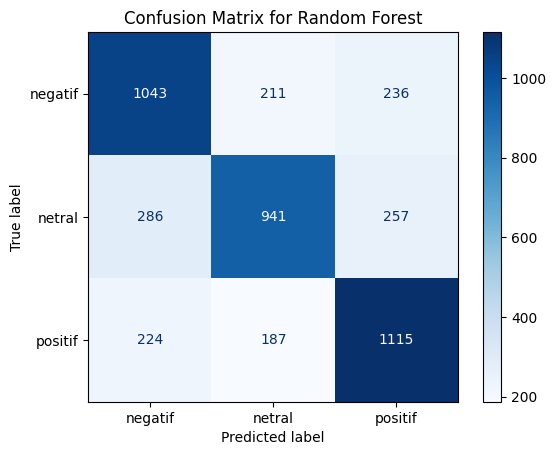

In [34]:
# Compute confusion matrix for Random Forest
rf_confusion_matrix = confusion_matrix(y_test_encoded, rf_pred)

# Plot confusion matrix for Random Forest
plt.figure(figsize=(8, 6))
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_confusion_matrix, display_labels=label_encoder.classes_)
rf_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Random Forest')
plt.show()